# Intro to pyro
You will create a model to invert the slope and y-intercept of a linear function

In [2]:
# library import
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

# Create a synthetic dataset
let's say that :
- slope=23
- y_intercept = 6000
We create a synthetic dataset with a linear function and add some random noise

data variancy: 463029.6005574494


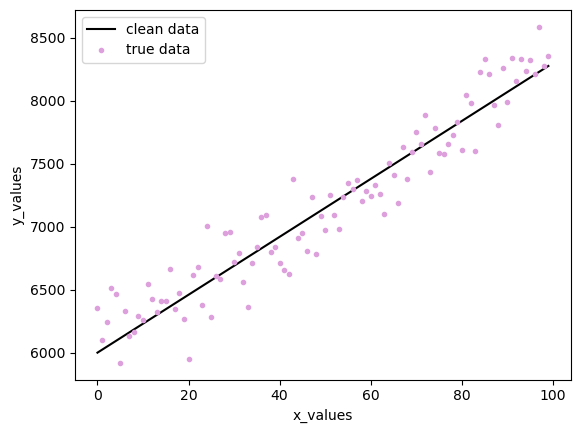

In [8]:
""" Creating synthetic dataset"""
x_values=np.arange(0, 100)
x_torch=torch.tensor(x_values)

def forward(a, b, x):
    y=a*x+b
    return y
slope_true = 23
y_intercept_true = 6000
clean_data = forward(slope_true, y_intercept_true, x_values) # clean dataset

"""Adding some noise"""
alpha = 200 # noise coeff
np.random.seed(0) # the same random noise is created each time
noise = np.random.randn(len(x_values)) * alpha # adding random noise
true_data = torch.tensor(clean_data+noise) # adding noise and using torch tensor
variancy = torch.var(true_data) # find the variancy of our synthetic dataset (useful later on)
print('data variancy:', variancy.detach().numpy())

"""Plotting"""
plt.plot(x_values, clean_data, color='black', label='clean data')
plt.plot(x_values, true_data, linestyle='', marker='.', color='plum', label='true data')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()

Sample: 100%|█| 1010/1010 [00:05, 196.18it/s, step size=4.24e-02, acc. prob=0.14


MCMC done 

slope: tensor(22.4779, dtype=torch.float64)
y-interc: tensor(6033.0788, dtype=torch.float64)


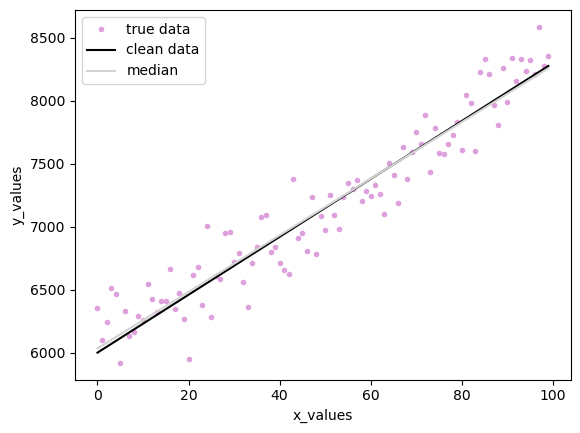

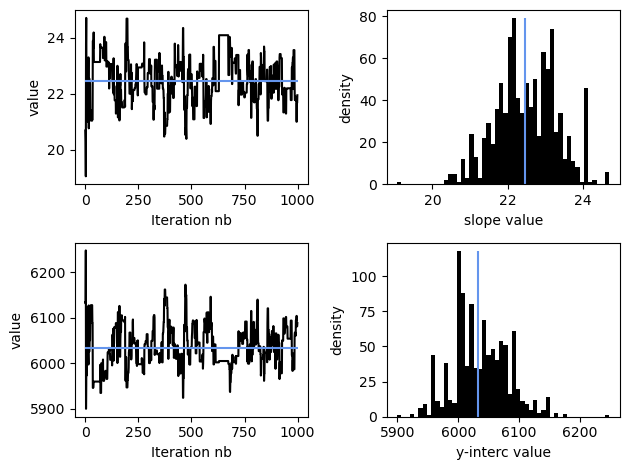

In [10]:
""" MCMC parameters """
pyro.set_rng_seed(200)# start from the same point
w_step = 10 # number of warmup (~30% of total models)
nb_sample = 1000 # number of samples
tree_depth = 4 # prob tree maximum depth (min: 4, max:10)
target_prob = 0.7 # target acceptancy probability (>1)

""" MCMC model """
def model(obs):
    
    infer_a=pyro.sample('a', dist.Uniform(0, 100))
    infer_b=pyro.sample('b', dist.Uniform(1000, 7*1e3))
    sigma=pyro.sample('sigma', dist.Uniform(0, variancy/1000))
    t = forward(infer_a, infer_b, x_torch)
    return pyro.sample('obs', dist.Normal(t, sigma), obs=obs)

""" usage MCMC """
kernel = NUTS(model, max_tree_depth=tree_depth, target_accept_prob=target_prob) # kernel (NUTS, HMC, ...)
mcmc = MCMC(kernel, warmup_steps=w_step, num_samples=nb_sample) # parametrization of MCMC
mcmc.run(obs = true_data) # run MCMC
print('MCMC done \n')

""" Post processing """
posterior_samples = mcmc.get_samples()

""" get values """
infered_slopes=posterior_samples['a']
infered_y_intercepts=posterior_samples['b']
median_slope=torch.median(infered_slopes)
median_y_int=torch.median(infered_y_intercepts)
infered_median_model=forward(median_slope, median_y_int, x_values)
print('slope:', median_slope)
print('y-interc:', median_y_int)

""" plotting """
plt.figure(num=1)
plt.plot(x_values, true_data, linestyle='', marker='.', color='plum', label='true data')
plt.plot(x_values, clean_data, color='black', label='clean data')
plt.plot(x_values, infered_median_model, color='lightgrey', label='median')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()

plt.figure(num=2)
plt.subplot(2,2,1)
plt.plot(infered_slopes, color='black', label='Slopes')
plt.hlines(median_slope, 0, nb_sample, color='cornflowerblue', label='Inferred slope')
plt.xlabel('Iteration nb')
plt.ylabel('value')
plt.subplot(2,2,2)
bar_heights, bins, patches=plt.hist(infered_slopes, bins=50, color='black', label='All slopes')
plt.vlines(median_slope, 0, np.max(bar_heights), color='cornflowerblue', label='Inferred slope')
plt.xlabel('slope value')
plt.ylabel('density')

plt.subplot(2,2,3)
plt.plot(infered_y_intercepts, color='black', label='Y-intercepts')
plt.hlines(median_y_int, 0, nb_sample, color='cornflowerblue', label='Inferred y-interc')
plt.xlabel('Iteration nb')
plt.ylabel('value')
plt.subplot(2,2,4)
bar_heights, bins, patches=plt.hist(infered_y_intercepts, bins=50, color='black', label='All y-interc')
plt.vlines(median_y_int, 0, np.max(bar_heights), color='cornflowerblue', label='Inferred y-interc')
plt.xlabel('y-interc value')
plt.ylabel('density')
plt.tight_layout()

Now let's define the following function to test the impact of the MCMC parameters

In [11]:
def invert_data(w_step, samples, tree_depth, target_prob):
    """ MCMC parameters """
    
    """w_step = 10 # number of warmup (~30% of total models)
    nb_sample = 1000 # number of samples
    tree_depth = 4 # prob tree maximum depth (min: 4, max:10)
    target_prob = 0.7 # target acceptancy probability (>1)"""

    """ MCMC model """
    pyro.set_rng_seed(20)
    def model(obs):

        infer_a=pyro.sample('a', dist.Uniform(0, 50))
        infer_b=pyro.sample('b', dist.Uniform(5*1e3, 7*1e3))
        sigma=pyro.sample('sigma', dist.Uniform(0, variancy))
        t = forward(infer_a, infer_b, x_values)
        return pyro.sample('obs', dist.Normal(t, sigma), obs=obs)

    """ usage MCMC """
    kernel = NUTS(model, max_tree_depth=tree_depth, target_accept_prob=target_prob) # kernel (NUTS, HMC, ...)
    mcmc = MCMC(kernel, warmup_steps=w_step, num_samples=nb_sample) # parametrization of MCMC
    mcmc.run(obs=true_data) # run MCMC
    print('MCMC done \n')

    """ Post processing """
    posterior_samples = mcmc.get_samples()

    """ get values """
    infered_slopes=posterior_samples['a']
    infered_y_intercepts=posterior_samples['b']
    median_slope=torch.median(infered_slopes)
    median_y_int=torch.median(infered_y_intercepts)
    infered_median_model=forward(median_slope, median_y_int, x_values)
    print('slope:', median_slope)
    print('y-interc:', median_y_int)

    """ plotting """
    plt.figure(num=1)
    plt.plot(x_values, true_data, linestyle='', marker='.', color='plum', label='true data')
    plt.plot(x_values, clean_data, color='black', label='clean data')
    plt.plot(x_values, infered_median_model, color='lightgrey', label='median')
    plt.xlabel('x_values')
    plt.ylabel('y_values')
    plt.legend()

    plt.figure(num=2)
    plt.subplot(2,2,1)
    plt.plot(infered_slopes, color='black', label='Slopes')
    plt.hlines(median_slope, 0, nb_sample, color='cornflowerblue', label='Inferred slope')
    plt.xlabel('Iteration nb')
    plt.ylabel('value')
    plt.subplot(2,2,2)
    bar_heights, bins, patches=plt.hist(infered_slopes, bins=50, color='black', label='All slopes')
    plt.vlines(median_slope, 0, np.max(bar_heights), color='cornflowerblue', label='Inferred slope')
    plt.xlabel('slope value')
    plt.ylabel('density')

    plt.subplot(2,2,3)
    plt.plot(infered_y_intercepts, color='black', label='Y-intercepts')
    plt.hlines(median_y_int, 0, nb_sample, color='cornflowerblue', label='Inferred y-interc')
    plt.xlabel('Iteration nb')
    plt.ylabel('value')
    plt.subplot(2,2,4)
    bar_heights, bins, patches=plt.hist(infered_y_intercepts, bins=50, color='black', label='All y-interc')
    plt.vlines(median_y_int, 0, np.max(bar_heights), color='cornflowerblue', label='Inferred y-interc')
    plt.xlabel('y-interc value')
    plt.ylabel('density')
    plt.tight_layout()



Run the next cell and vary the parameters

In [12]:
invert_data(w_step=100, samples=200, tree_depth=4, target_prob=0.7)

Warmup:   0%|                                            | 0/1100 [00:00, ?it/s]

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.
Trace Shapes:  
 Param Sites:  
Sample Sites:  
       a dist |
        value |
       b dist |
        value |
   sigma dist |
        value |

#### 